In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.autograd import Variable

import sys
import time
import numpy as np
import random
import matplotlib.pyplot as plt

from utils import *

# Auto-reloading of modules in iPython
%load_ext autoreload
%autoreload 2

In [2]:
# # !pip install music21
# # !pip install pretty_midi
# # !pip install playsound
# # !pip install librosa
# import os
# from pathlib import Path
# from music21 import *
# import pretty_midi
# import glob
# from playsound import playsound
# from scipy.io.wavfile import read, write
# import IPython
# import librosa.display

In [3]:
# CONSTS
random_seed = 11
seq_size = 25
validation_size = 0.15
learning_rate = 1e-3
epchs = 100
num_layers = 2
hidden_size = 150
dropout = 0.2
model_type = 'lstm'
use_cuda = False
print("use_cuda is: %s" % use_cuda)

torch.manual_seed(random_seed)
input_music = 'data/jigs.txt'  # Music

use_cuda is: False


In [4]:
# Read data file
f = open(input_music,"r")
data, buffer = [], ''
store = False
for line in f:
    if 'X' in line:
        buffer += line
    elif line == "\n":
        buffer += line
        data += [buffer]
        buffer = ''
    else:
        buffer += line
f.close()

data = [ song for song in data if len(song) > seq_size + 10 ]
print(data[0])

X: 1
T:A and D
% Nottingham Music Database
S:EF
M:4/4
K:A
M:6/8
P:A
f|"A"ecc c2f|"A"ecc c2f|"A"ecc c2f|"Bm"BcB "E7"B2f|
"A"ecc c2f|"A"ecc c2c/2d/2|"D"efe "E7"dcB| [1"A"Ace a2:|
 [2"A"Ace ag=g||\
K:D
P:B
"D"f2f Fdd|"D"AFA f2e/2f/2|"G"g2g ecd|"Em"efd "A7"cBA|
"D"f^ef dcd|"D"AFA f=ef|"G"gfg "A7"ABc |1"D"d3 d2e:|2"D"d3 d2||




In [5]:
# wd = os.getcwd()
# p = Path()
# song = data[0]
# score = converter.parse(song)
# # score.write('xml', fp=p/'song')
# # score_paths = p.glob('xml/*.xml')
# score = converter.parse(str(wd)+ "/song.xml")
# score.show()

In [6]:
char_idx = ''.join(set(list(open(input_music,'r').read())))
char_list = list(char_idx)

# Split training and validation set
num_train = len(data)
indices = list(range(num_train))
split_idx = int(np.floor(validation_size * num_train))

# Shuffle and split
np.random.seed(random_seed)
np.random.shuffle(indices)
train_idxs, valid_idxs = indices[split_idx:], indices[:split_idx]

train_len, valid_len = len(train_idxs), len(valid_idxs)
print('Number of unique characters: %s' % len(char_idx))
print('Original data length: %s' % len(data))
print('Training data length: %s'% train_len)
print('Validation data length: %s' % valid_len)
assert(train_len + valid_len == len(data)), 'Train_len + valid_len should == len(data)'

Number of unique characters: 87
Original data length: 340
Training data length: 289
Validation data length: 51


In [7]:
def rand_slice(data, slice_len=seq_size):
    data_len = len(data)
    start = random.randint(0, data_len - slice_len)
    end = start + slice_len + 1
    return data[start:end]

def seq_to_tensor(seq):
    out = torch.zeros(len(seq)).long()
    for i, c in enumerate(seq):
        out[i] = char_idx.index(c)
    return out

def song_to_seq_target(song):
    rand_seq = rand_slice(song)
    seq = seq_to_tensor(rand_seq[:-1])
    target = seq_to_tensor(rand_seq[1:])
    assert(len(seq) == len(target)), 'SEQ AND TARGET MISMATCH'
    return seq, target

s, t = song_to_seq_target(data[0])
print(s.size())
assert(t.data[0] == s.data[1])

torch.Size([25])


In [8]:
class MusicRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model='gru', num_layers=1):
        super(MusicRNN, self).__init__()
        self.model = model
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        self.embeddings = nn.Embedding(input_size, hidden_size)
        if self.model == 'lstm':
            self.rnn = nn.LSTM(hidden_size, hidden_size, num_layers)
        elif self.model == 'gru':
            self.rnn = nn.GRU(hidden_size, hidden_size, num_layers)
        else:
            raise NotImplementedError
            
        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.drop = nn.Dropout(p=dropout)
        
    def init_hidden(self):
        if self.model == 'lstm':
            self.hidden = (torch.zeros(self.num_layers, 1, self.hidden_size),
                           torch.zeros(self.num_layers, 1, self.hidden_size))
        elif self.model == 'gru':
            self.hidden = torch.zeros(self.num_layers, 1, self.hidden_size)
        
    def forward(self, seq):
        embeds = self.embeddings(seq.view(1, -1))
        rnn_out, self.hidden = self.rnn(embeds.view(1,1,-1), self.hidden)
        rnn_out = self.drop(rnn_out)
        output = self.out(rnn_out.view(1,-1))
        return output

In [9]:
def calculate_loss(seq, target, fit=True):
    model.init_hidden() 
    model.zero_grad()   
    loss = 0
    
    for i, c in enumerate(seq):
        output = model(c)
#         print(output.shape)
#         print(target[i])
        loss += loss_function(output, target[i].unsqueeze(0))
        
    if fit:
        loss.backward()
        optimizer.step()
    
    return loss.item() / len(seq)

In [10]:
# Model
in_size, out_size = len(char_idx), len(char_idx)
model = MusicRNN(in_size, hidden_size, out_size, model_type, num_layers)
t_loss, v_loss = 0, 0
t_losses, v_losses = [], []

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

In [11]:
# Train
for epoch in range(epchs):
    # Training
    for i, song_idx in enumerate(train_idxs):
        loss = calculate_loss(*song_to_seq_target(data[song_idx]))
        t_loss += loss
        
        msg = '\rTraining Epoch: {}, {:.2f}% iter: {} Loss: {:.4}'.format(
             epoch, (i+1)/len(train_idxs)*100, i, loss)
        sys.stdout.write(msg)
        sys.stdout.flush()
    print()
    t_losses.append(t_loss / len(train_idxs))
        
    # Validation
    for i, song_idx in enumerate(valid_idxs):
        loss = calculate_loss(*song_to_seq_target(data[song_idx]), fit=False)
        v_loss += loss
        
        msg = '\rValidation Epoch: {}, {:.2f}% iter: {} Loss: {:.4}'.format(
             epoch, (i+1)/len(valid_idxs)*100, i, loss)
        sys.stdout.write(msg)
        sys.stdout.flush()
    print()
    v_losses.append(v_loss / len(valid_idxs))
    
    t_loss, v_loss = 0, 0

Training Epoch: 0, 100.00% iter: 288 Loss: 2.853
Validation Epoch: 0, 100.00% iter: 50 Loss: 1.978
Training Epoch: 1, 100.00% iter: 288 Loss: 1.446
Validation Epoch: 1, 100.00% iter: 50 Loss: 1.447
Training Epoch: 2, 100.00% iter: 288 Loss: 1.453
Validation Epoch: 2, 100.00% iter: 50 Loss: 1.529
Training Epoch: 3, 100.00% iter: 288 Loss: 1.437
Validation Epoch: 3, 100.00% iter: 50 Loss: 1.383
Training Epoch: 4, 100.00% iter: 288 Loss: 1.351
Validation Epoch: 4, 100.00% iter: 50 Loss: 1.468
Training Epoch: 5, 100.00% iter: 288 Loss: 1.196
Validation Epoch: 5, 100.00% iter: 50 Loss: 1.331
Training Epoch: 6, 100.00% iter: 288 Loss: 1.272
Validation Epoch: 6, 100.00% iter: 50 Loss: 1.415
Training Epoch: 7, 100.00% iter: 288 Loss: 1.605
Validation Epoch: 7, 100.00% iter: 50 Loss: 1.992
Training Epoch: 8, 100.00% iter: 288 Loss: 1.719
Validation Epoch: 8, 100.00% iter: 50 Loss: 1.267
Training Epoch: 9, 100.00% iter: 288 Loss: 1.3717
Validation Epoch: 9, 100.00% iter: 50 Loss: 1.4165
Training

Validation Epoch: 79, 100.00% iter: 50 Loss: 1.132
Training Epoch: 80, 100.00% iter: 288 Loss: 0.72482
Validation Epoch: 80, 100.00% iter: 50 Loss: 0.8931
Training Epoch: 81, 100.00% iter: 288 Loss: 1.052
Validation Epoch: 81, 100.00% iter: 50 Loss: 1.291
Training Epoch: 82, 100.00% iter: 288 Loss: 0.71621
Validation Epoch: 82, 100.00% iter: 50 Loss: 1.272
Training Epoch: 83, 100.00% iter: 288 Loss: 0.52178
Validation Epoch: 83, 100.00% iter: 50 Loss: 1.299
Training Epoch: 84, 100.00% iter: 288 Loss: 0.8731
Validation Epoch: 84, 100.00% iter: 50 Loss: 1.004
Training Epoch: 85, 100.00% iter: 288 Loss: 0.2645
Validation Epoch: 85, 100.00% iter: 50 Loss: 0.9683
Training Epoch: 86, 100.00% iter: 288 Loss: 1.02975
Validation Epoch: 86, 100.00% iter: 50 Loss: 0.9727
Training Epoch: 87, 100.00% iter: 288 Loss: 0.90417
Validation Epoch: 87, 100.00% iter: 50 Loss: 1.208
Training Epoch: 88, 100.00% iter: 288 Loss: 0.77722
Validation Epoch: 88, 100.00% iter: 50 Loss: 0.9704
Training Epoch: 89, 10

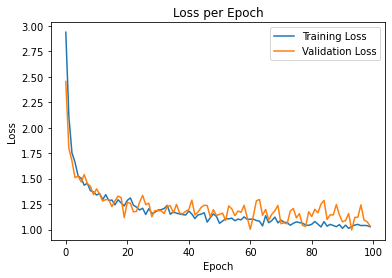

In [12]:
plt.plot(t_losses, label='Training Loss')
plt.plot(v_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.show()

In [13]:
def write_song(prime_str='X', max_len=1000, temp=0.8):
    model.init_hidden()
    
    output = 'X'
    prime = seq_to_tensor(output)
    for i in range(len(prime)-1):
        _ = model(prime[i])

    for j in range(max_len):
        out = model(seq_to_tensor(output[-1])).data.view(-1)
        
        out = np.array(np.exp(out/temp))
        dist = out / np.sum(out)
      
        output += char_idx[np.random.choice(len(dist), p=dist)]
        if output[-3:] == '/n':
            break

    return output

In [21]:
sample_song = write_song(max_len=1000, temp=0.8)
print(sample_song)
with open("sample_song.txt", "w") as text_file:
    print(sample_song, file=text_file)

X: 53
T:Statkin Briggs, via EF
M:6/8
K:C
P:A
B/2A/2|"G"G2G GAB|A2B B2c|"G7"d^cd BGE|"C"e3 ecA|"D7"d3 -d3|"A7"edc BAG|"D"A2B "Em"B2d|\
"D7"f2e "Bm"dcB|"Am"cBc "D"d2:|
P:B
e|"D"fed "A7"ecA|"G"Bcd "A7"edc|"D"d2e f2a|b2f "D"fga|"Em"gfe edB|"Em"def gfg|"A"acc cBA|"Bm"Bcd "A"ecA|"D"dfa afa|"Bm"d2d "E7"efg|"D"faa "A7"a3|"Dm"faf d2A|d2d def|"G"gfg "Bm"f2d|"Em"e2d "A7"edc|"D"d3 -d^cA|E
"Em"D3 E2::
|:e|"D"f2e "D7"fed|"C"cde "G"d2d|"C"e3 -efg|\
"G"d2B "A7"A2c|"D"d2d d2::
G|"F"A2A A2A|"D"d2A ABA|"D"d3 "A7"d3|"G"B3 e2"E7"BAB|"Am"c3 A3|"D7"cBA FED|"C"e3 e3|"C"efg g2f|"G"g2a g2f|
"Em"gef gfe|
"A7"d2c "D7"d3|
"G"d2d B3|"G"d3 "G7"f2d|
"C"e2g g3|"C"e2e "G7"cBc|"C"c2c cBc|G2c e^fg|"Gm"G2G G2B|"C"c2B c2d|"G"B2d B2B|"G"BGE B2d|"C"e2d "Am"c2A|"G"B2A B2A|"D"A2F "Em"G2E|"DEF "E7"E2D|
"Em"GEE EFG|"A"A2A "D7"FED|"C"C3 -EFE|
"F"F2E F2A|"C"G2G G2z|"F7"FE=F =FEF|"G"G2G G2A|"G"B2G "D7"A2G|"C"e2c ABc|"D"d3 dcB|c2A A2d|c2A AGA|E2F F2E|"D"DFA A2B|"A7"[E3c][B3d]![2^:c
f|"D"dff fed|"A"cec "E7"cAB|"A"A2E A2A|"D"FAB a2f|"